In [1]:
import tensorflow as tf
import datasets
import transformers
import numpy as np
from transformers import TFAutoModelForSequenceClassification

In [2]:
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)
model.load_weights("epoch3/mesh_model_checkpoint")

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("json", data_files={"train": "dataset/mesh_train.json","validation":"dataset/mesh_val.json",
                                                "test": "dataset/mesh_test.json", "30_test":"dataset/30_articles.json"})

datasets = load_dataset("json", data_files={"whole":["dataset/mesh_train.json","dataset/mesh_val.json","dataset/mesh_test.json"]})

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["text"])


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_whole_datasets = datasets.map(tokenize_function, batched=True)

# put together samples inside a batch and convert your samples to tf.Tensor and concatenate them
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=2,
)

tf_validation_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=2,
)

tf_test_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=2,
)

tf_30test_dataset = tokenized_datasets["30_test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=2,
)

Using custom data configuration default-65c47fb3ef1db577
Reusing dataset json (C:\Users\13056\.cache\huggingface\datasets\json\default-65c47fb3ef1db577\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/4 [00:00<?, ?it/s]

Using custom data configuration default-1948e17679d22c95
Reusing dataset json (C:\Users\13056\.cache\huggingface\datasets\json\default-1948e17679d22c95\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

In [4]:
tf_trainn_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=2,
)

tf_all_dataset = tokenized_whole_datasets["whole"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=2,
)

### Training dataset

In [5]:
train_pred = model.predict(tf_trainn_dataset)["logits"]
train_class_pred = np.argmax(train_pred, axis=1)
train_score = np.mean(train_class_pred==raw_datasets["train"]["label"])
print(train_pred.shape, train_class_pred.shape)
print("accuracy",train_score)

(2000, 2) (2000,)
accuracy 0.9635


In [6]:
from sklearn import metrics
f1 = metrics.f1_score(raw_datasets["train"]["label"],train_class_pred, average="macro")
print(metrics.classification_report(raw_datasets["train"]["label"], train_class_pred))
print("Macro-F1 score:{0}".format(f1))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1000
           1       0.99      0.94      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000

Macro-F1 score:0.9634798317370767


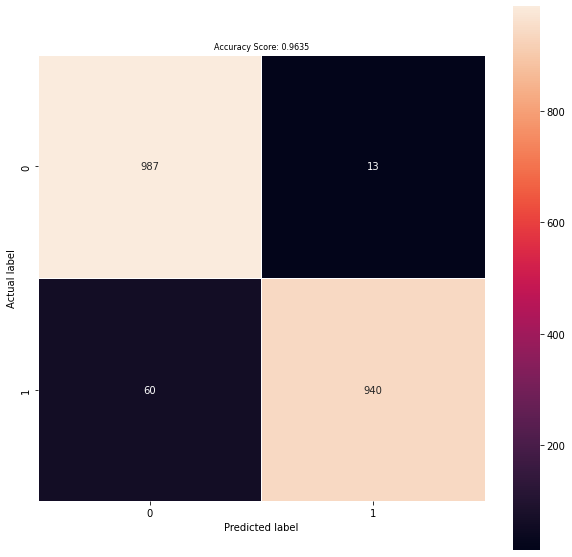

In [7]:
## Evaluate the model
import seaborn as sns
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(raw_datasets["train"]["label"], train_class_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=1, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Accuracy Score: {0}'.format(train_score), size = 8);

### Validation dataset

In [8]:
val_pred = model.predict(tf_validation_dataset)["logits"]
val_class_pred = np.argmax(val_pred, axis=1)
val_score = np.mean(val_class_pred==raw_datasets["validation"]["label"])
print(val_pred.shape, val_class_pred.shape)
print("accuracy",val_score)

(1000, 2) (1000,)
accuracy 0.912


In [9]:
from sklearn import metrics
f1 = metrics.f1_score(raw_datasets["validation"]["label"],val_class_pred, average="macro")
print(metrics.classification_report(raw_datasets["validation"]["label"], val_class_pred))
print("Macro-F1 score:{0}".format(f1))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       500
           1       0.91      0.92      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

Macro-F1 score:0.9119985919774716


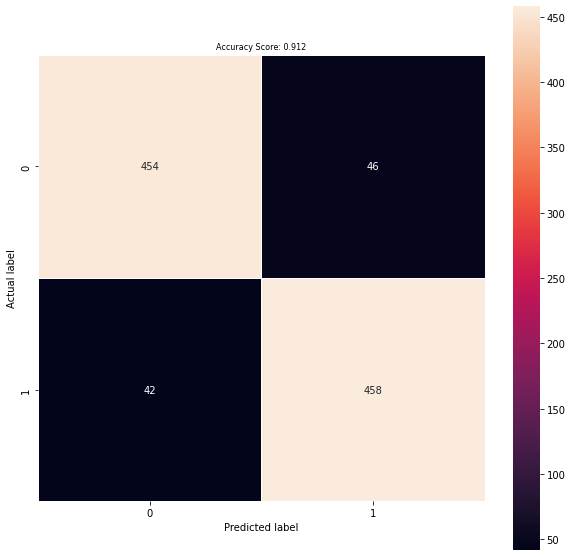

In [10]:
## Evaluate the model
import seaborn as sns
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(raw_datasets["validation"]["label"], val_class_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=1, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Accuracy Score: {0}'.format(val_score), size = 8);

### Test dataset

In [11]:
test_pred = model.predict(tf_test_dataset)["logits"]
test_class_pred = np.argmax(test_pred, axis=1)
test_score = np.mean(test_class_pred==raw_datasets["test"]["label"])
print(test_pred.shape, test_class_pred.shape)
print("accuracy",test_score)

(13953, 2) (13953,)
accuracy 0.7057980362646026


In [12]:
from sklearn import metrics
f1 = metrics.f1_score(raw_datasets["test"]["label"],test_class_pred, average="macro")
print(metrics.classification_report(raw_datasets["test"]["label"], test_class_pred))
print("Macro-F1 score:{0}".format(f1))

              precision    recall  f1-score   support

           0       1.00      0.70      0.82     13707
           1       0.05      0.92      0.10       246

    accuracy                           0.71     13953
   macro avg       0.53      0.81      0.46     13953
weighted avg       0.98      0.71      0.81     13953

Macro-F1 score:0.4618788270345299


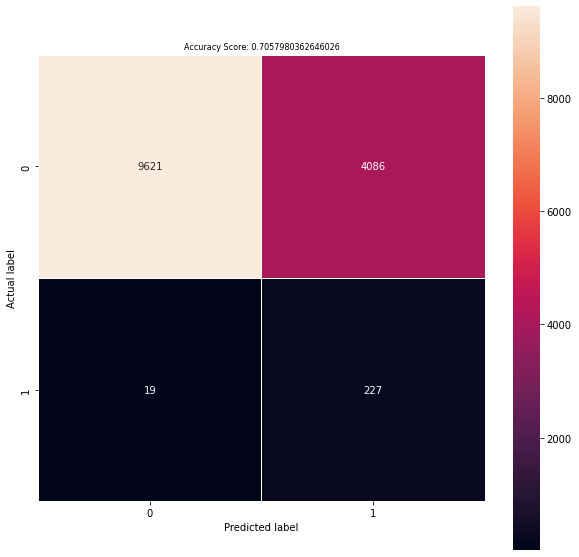

In [13]:
## Evaluate the model
import seaborn as sns
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(raw_datasets["test"]["label"], test_class_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=1, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Accuracy Score: {0}'.format(test_score), size = 8);

### 30 articles


In [14]:
test_pred = model.predict(tf_30test_dataset)["logits"]
test_class_pred = np.argmax(test_pred, axis=1)
test_score = np.mean(test_class_pred==raw_datasets["30_test"]["label"])
print(test_pred.shape, test_class_pred.shape)
print("accuracy",test_score)

(30, 2) (30,)
accuracy 0.7666666666666667


In [15]:
from sklearn import metrics
f1 = metrics.f1_score(raw_datasets["30_test"]["label"],test_class_pred, average="macro")
print(metrics.classification_report(raw_datasets["30_test"]["label"], test_class_pred))
print("Macro-F1 score:{0}".format(f1))

              precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.70      0.93      0.80        15

    accuracy                           0.77        30
   macro avg       0.80      0.77      0.76        30
weighted avg       0.80      0.77      0.76        30

Macro-F1 score:0.76


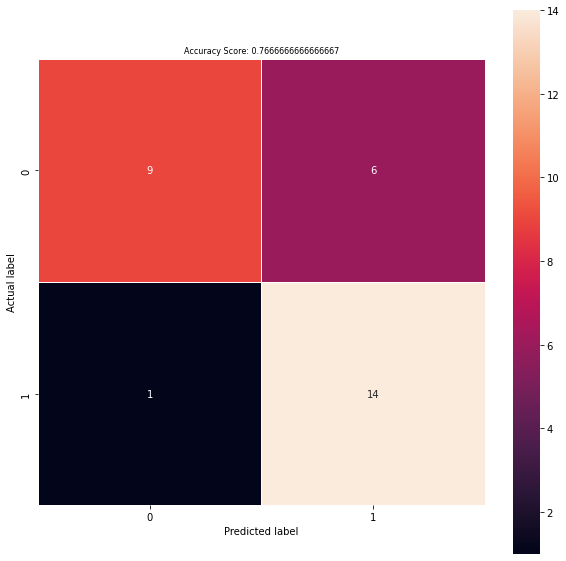

In [16]:
## Evaluate the model
import seaborn as sns
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(raw_datasets["30_test"]["label"], test_class_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=1, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Accuracy Score: {0}'.format(test_score), size = 8);

In [17]:
for i in range(30):
    if test_class_pred[i] == 0 and int(raw_datasets["30_test"]["label"][i]) == 1:
        print("NO: %d" % (i+1) , "has qualifier while classfied as negative")
    if test_class_pred[i] == 1 and int(raw_datasets["30_test"]["label"][i]) == 0:
        print("NO: %d" % (i+1) , "doesn't have qualifier while classfied as positive") 

NO: 5 doesn't have qualifier while classfied as positive
NO: 6 doesn't have qualifier while classfied as positive
NO: 7 doesn't have qualifier while classfied as positive
NO: 18 has qualifier while classfied as negative
NO: 22 doesn't have qualifier while classfied as positive
NO: 24 doesn't have qualifier while classfied as positive
NO: 26 doesn't have qualifier while classfied as positive


In [18]:
print(test_class_pred)

[1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1]


### The whole dataset

In [19]:
test_pred = model.predict(tf_all_dataset)["logits"]
test_class_pred = np.argmax(test_pred, axis=1)
test_score = np.mean(test_class_pred==datasets["whole"]["label"])
print(test_pred.shape, test_class_pred.shape)
print("accuracy",test_score)

(16953, 2) (16953,)
accuracy 0.7483631215714033


In [20]:
from sklearn import metrics
f1 = metrics.f1_score(datasets["whole"]["label"],test_class_pred, average="macro")
print(metrics.classification_report(datasets["whole"]["label"], test_class_pred))
print("Macro-F1 score:{0}".format(f1))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84     15207
           1       0.28      0.93      0.43      1746

    accuracy                           0.75     16953
   macro avg       0.64      0.83      0.64     16953
weighted avg       0.92      0.75      0.80     16953

Macro-F1 score:0.6353793579381292


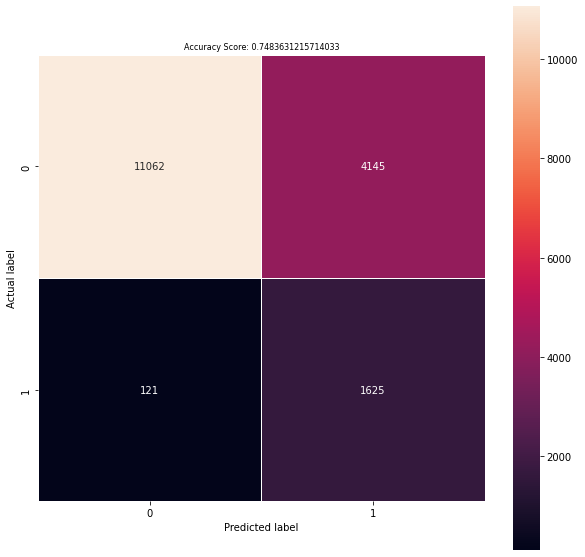

In [21]:
## Evaluate the model
import seaborn as sns
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(datasets["whole"]["label"], test_class_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=1, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Accuracy Score: {0}'.format(test_score), size = 8);